In [1]:
#Festlegen der random-Werte für eine bessere Reproduzierbarkeit
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

#Generelle Bibliotheken
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 
import os
import pandas as pd 
from PIL import Image
import cv2

#Keras Bibliotheken zur Erstellung des Netzes
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import InputLayer
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import keras.metrics
from keras.optimizers import Adam

#Bibliotheken zur Erstellung von Performance-Ergebnissen
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score

Using TensorFlow backend.


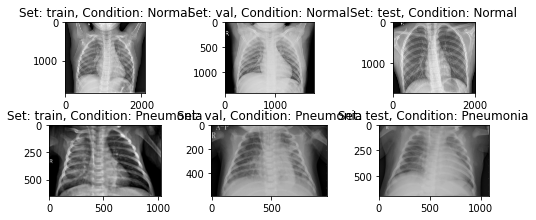

In [2]:
#Festlegen des Input-Pfads
input_path = "C:\\Users\\Carlo Zimmerd\\input\\chest_xray_200\\"

#Ausgabe beispielhafter Samples der Datensätze
fig, ax = plt.subplots(2, 3, figsize=(7, 3))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [3]:
#Verteilung des Datensatzes
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 100, pneumonia images: 100
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 100, pneumonia images: 100


In [4]:
#Vorverarbeitung des Datensatzes
def process_data(img_dims, batch_size):
    #Data-Augmentation des Trainingsdatensatzes durch Reskalierung, Zoom und horizontaler Drehung
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       zoom_range=0.2,
                                       horizontal_flip=True)    
    #Data-Augmentation der Validierungs- und Testdaten durch Reskalierung
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    #Anwendung der Vorverarbeitung auf die Trainingsdaten und Zuordnung der Batch_size und des Klassifizierungmodus
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train',     
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
 
    #Anwendung der Vorverarbeitung auf die Testdaten und Zuordnung der Batch_size und des Klassifizierungmodus
    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    #Zuordnung der jeweiligen Bildklassen-Labels in ein Array, bestehend aus '1' für Normal und '0' für Pneumonia
    #Dies wird für die spätere Erstellung der Test-Messungen, wie der Konvusionsmatrix genutzt
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)

    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [5]:
#Festlegen der Hyperparameter
img_dims = 224
epochs = 10
batch_size = 4
input_shape = (img_dims, img_dims, 3)
INIT_LR = 1e-4

#Überprüfen der Datenmengen
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [6]:
#Erstellen der Netz-Architektur
def create_cnn():
    
    #Übernahme der VGG19-Architektur mit den ImageNet-Gewichtungen. 
    #Der Fully-Connected-Teil wird nicht übernommen
    vgg19 = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)
    
    #Alle Schichten des VGG19 werden als untrainierbar festgelegt
    for layer in vgg19.layers:
        layer.trainable = False
        
    #Festlegung der finalen gesamenten Netzarchitektur
    cnn = Sequential()
    cnn.add(vgg19)
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(Flatten())
    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(1, activation='sigmoid'))
    
    return cnn

cnn = create_cnn()


#Festlegung der verwendeten Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights_vgg19_fe.h5', verbose = 2, save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')

#Festlegung des Optimizers, Kompilierung des Netzes und Ausgabe der Zusammenfassung
opt = Adam(lr=INIT_LR)
cnn.compile(loss="binary_crossentropy", optimizer= opt, metrics=["accuracy"])
cnn.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                294976    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________________________________________________________

In [7]:
#Anpassung und Training des Netzes, Festlegung der Epochen und Anzahl an Schritten pro Epoche bzw. Validierung
cnn_model = cnn.fit_generator(train_gen,
                         steps_per_epoch = train_gen.samples // batch_size,
                         epochs = epochs,
                         validation_data = test_gen,
                         validation_steps = test_gen.samples // batch_size,
                         callbacks = [checkpoint, lr_reduce])

Epoch 1/10
50/50 [==============================] - 182s 4s/step - loss: 0.7084 - acc: 0.5450 - val_loss: 0.5683 - val_acc: 0.8250

Epoch 00001: val_loss improved from inf to 0.56829, saving model to best_weights_vgg19_fe.h5
Epoch 2/10
50/50 [==============================] - 183s 4s/step - loss: 0.5157 - acc: 0.8100 - val_loss: 0.5005 - val_acc: 0.7900

Epoch 00002: val_loss improved from 0.56829 to 0.50055, saving model to best_weights_vgg19_fe.h5
Epoch 3/10
50/50 [==============================] - 190s 4s/step - loss: 0.4167 - acc: 0.8400 - val_loss: 0.4582 - val_acc: 0.8300

Epoch 00003: val_loss improved from 0.50055 to 0.45823, saving model to best_weights_vgg19_fe.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
Epoch 4/10
50/50 [==============================] - 184s 4s/step - loss: 0.3537 - acc: 0.9000 - val_loss: 0.4564 - val_acc: 0.7750

Epoch 00004: val_loss improved from 0.45823 to 0.45635, saving model to best_weights_vgg19_fe.h5
Epoch 

In [8]:
#Ausgabe finalen Trainingsgenauigkeit
print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((cnn_model.history['acc'][-1])*100, 2)))
print('Val acc: {}'.format(np.round((cnn_model.history['val_acc'][-1])*100, 2)))


TRAIN METRIC ----------------------
Train acc: 90.0
Val acc: 80.0


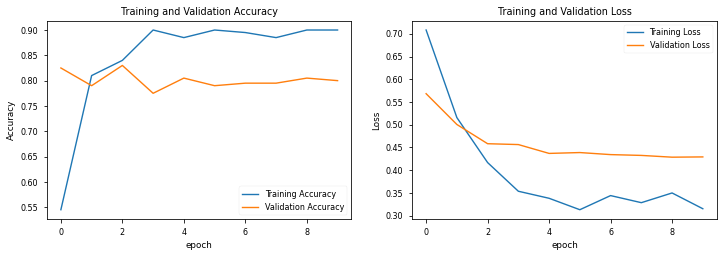

In [9]:
#Ausgabe der Grafiken zum Trainingsverlauf
def plot_accuraccy(history):
    plt.style.use('seaborn-paper')
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('epoch')

    plt.subplot(2, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
    
plot_accuraccy(cnn_model) 

In [10]:
#Es werden die gespeicherten besten Gewichtungen aufgerufen und einem neu erstellten Netz zugewiesen, 
#sodass sich 1 zu 1 das gleiche Netz ergibt, das über den Trainingsverlauf die besten Ergebnisse erzielen konnte
cnn_model = create_cnn()
cnn_model.load_weights('best_weights_vgg19_fe.h5')

CONFUSION MATRIX ------------------
[[73 27]
 [13 87]]

TEST METRICS ----------------------
Accuracy: 80.0%
Precision: 76.31578947368422%
Recall: 87.0%
F1-score: 81.30841121495327


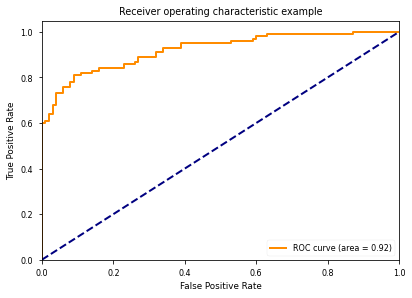

In [11]:
#Erstellung der Test-Messgrößen und Ausgabe der Testergebnisse
from sklearn.metrics import accuracy_score, confusion_matrix

preds = cnn.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))


fpr , tpr , thresholds = roc_curve (test_labels, preds)
auc_keras = auc(fpr, tpr)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.show()